# PROYECTO CLASIFICACIÓN DE TEXTO

Este artefacto hace parte del entregable **Alcanzando los objetivos de desarrollo sostenible. Un aporte desde el machine learning**, actividad de la asignatura de Machine Learning no Supervisado de la Maestria de Inteligencia Artificial de la Univerisdad de los Andes.

 Integrantes:
 - Jaime Alberto Rodriguez - 200717791
 - Yezid Alejandro Garcia - 200810710 

# ANALISIS DEL PROBLEMA - COMPRENSIÓN DEL NEGOCIO

Se busca desarrollar un método automatizado que realice clasificaciones sobre textos, alineados con los objetivos de desarrollo sostenible definidos por la ONU. Esto podra ser de utilidad como herramienta de apoyo para analizar escritos, objetivos o proyectos y evaluar de forma prematura su alineación con los mencionados objetivos.

## Selección de Algoritmos

Para garantizar el exito del proyecto se han seleccionado 3 algoritmos que si bien tienen como proposito la clasificación, tienen caracteristicas propias que seran de utilidad para el procesamiento de disintos tipos de textos. Consideramos que el uso combinado o comparativo de estos algoritmos ofreceran distintas perspectivas y ventajas en la tarea de realizar clasificaciones de texto, abarcando diferentes características y requisitos de los textos que se procesen:

| __Algoritmo__ | __Descripción__ | __Ventaja Frente al Problema__ |
|-----------|-----------|-----------|
| Logistic Regression   |  Es un clasificador lineal que modela probabilidades (multiclase vía softmax o One-vs-Rest) con regularización (L1/L2).   | Es rapido y escalable ademas de ser adecuado para espacios de alta dimensión y dispersos como los encontrados en BOW/TF‑IDF.   |
| Random Forest   |Ensamble de árboles con bagging y submuestreo de características que captura relaciones no lineales.    | Su robustez al ruido le permite capturar relaciones no lineales e interacciones entre características.   |
| K-Neighbors (KNN)   | Clasificador no parametrico basado en vecinos más cercanos según una métrica de distancia.    | Ofrece una solución simple y efectiva sin necesidad de un entrenamiento costoso, gracias a la definición de distancias significativas y vecindarios bien definidos luego de aplicar alguna tecnica de reducción de dimensionalidad.    |

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import TransformerMixin, BaseEstimator


from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE


__Carga y Exploración Inicial de Datos__
Carga el dataset desde el archivo Train_textosODS.xlsx. Se crea una copia (_data_) para trabajar sobre ella sin modificar el original.

In [17]:
raw_data = pd.read_excel('data/Train_textosODS.xlsx')
data = raw_data.copy()
data.head()

,textos,ODS
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,No dejar clara la naturaleza de estos riesgos ...,6
2,"Como resultado, un mayor y mejorado acceso al ...",13
3,Con el Congreso firmemente en control de la ju...,16
4,"Luego, dos secciones finales analizan las impl...",5


__Split del dataset__ se dividen los datos en entrenamiento y pruebas 80/20, así se garantiza que el modelo se evalúe con textos que no ha visto durante el aprendizaje, asegurando una medida objetiva de su capacidad de generalización.

In [18]:
x_train, x_test, y_train, y_test = train_test_split(data['textos'], data['ODS'], test_size=0.2, random_state=42)  

__Descarga de Recursos para Preprocesamiento__ Se descargan las _stopwords?, que es el corpus de palabras con bajo valor semantico que provee nltk. 

Es un paso preparatorio indispensable para la limpieza de los textos que se realizará dentro del pipeline

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I864098/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

__Definición de Estrategias__ Se define un diccionario que parametriza el pipeline para obtener las bolsas de palabras, a la vez es la parte experimental en la reducción de dimensionalidad.

Cada diccionario representa una combinación única de vectorización de texto (count para Bag-of-Words o tfidf para TF-IDF) y una técnica de reducción de dimensionalidad (svd o pca). Esto permite probar y comparar sistemáticamente cuatro pipelines de preparación de datos, lo cual es fundamental para justificar la elección final del método, como lo solicita el proyecto.

Igualmente, cada diccionario define placeholders para almacenar los datos de entrenamiento y pruebas resultantes de la transformación.

In [20]:
bow_list =[
    {
        "vectorized": "count",
        "reduction": "svd",
        "train_data": None,
        "test_data": None
    },
    {
        "vectorized": "tfidf",
        "reduction": "svd",
        "train_data": None,
        "test_data": None
    },
    {
        "vectorized": "count",
        "reduction": "pca",
        "train_data": None,
        "test_data": None
    },
    {
        "vectorized": "tfidf",
        "reduction": "pca",
        "train_data": None,
        "test_data": None
    }
]

__Preprocesador de Texto__ Esta clase que hereda de BaseEstimator y TransformerMixin de sklearn para ser compatible con los pipelines, encapsula los pasos de preprocesamiento de texto:
1. Tokenización: Divide el texto en palabras (RegexpTokenizer).
2. Eliminación de Stopwords: Filtra las palabras de bajo valor semántico del Español.
3. Stemming: Reduce las palabras a su raíz (PorterStemmer). 

Este transformador es el primer paso del pipeline de preparación de datos.

In [21]:
class TextPreprocessorTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):            
        return X.apply(self.text_preprocess)
    
    def text_preprocess(self, text):
        tokenizer = RegexpTokenizer(r'\w+')
        stemmer = PorterStemmer()
    
        tokens = tokenizer.tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('spanish')]
        tokens = [stemmer.stem(word) for word in tokens]
        return ' '.join(tokens)

__Transformador a Matriz Densa__ La clase ToDenseTransformer se crea como un paso auxiliar dentro del pipeline. La salida de los vectorizadores de texto suele ser una matriz dispersa (sparse matrix) para ahorrar memoria. Sin embargo, el algoritmo PCA de sklearn requiere una matriz densa como entrada.

Este transformador se encarga de realizar esta conversión, permitiendo que PCA funcione correctamente dentro del pipeline.

In [22]:
class ToDenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.toarray()

__Factory de Pipelines__ Esta clase construye el objeto Pipeline son sus respecivos pasos para preparar los datos, utiliza las clases previamente definidas y se basa en los parámetros de vectorización ('count' o 'tfidf') y reducción ('svd' o 'pca'):
1. El preprocesamiento de texto (TextPreprocessorTransformer).
2. La vectorización (usando CountVectorizer o TfidfVectorizer).
3. La reducción de dimensionalidad (usando TruncatedSVD o PCA).
    - TruncatedSVD es la base del Análisis Semántico Latente (LSI), una técnica que proyecta documentos y palabras en un espacio de baja dimensión para descubrir conceptos semánticos. 
    - Ó, PCA como otro método de extracción de características que logra un fin similar.

In [27]:
class DataProcessingPipelineFactory:
    def get_pipelines_and_params(self, vectorizer, reduction):        

        steps = [
            ('preprocess', TextPreprocessorTransformer())             
        ]
        if vectorizer == 'count':
            steps.append(('vectorizer', CountVectorizer()))
        if vectorizer == 'tfidf':
            steps.append(('vectorizer', TfidfVectorizer()))
        if reduction == 'svd':
            steps.append(('dimred', TruncatedSVD(n_components=100)))
        if reduction == 'pca':
            steps.append(('to_dense', ToDenseTransformer()))             
            steps.append(('dimred', PCA(n_components=100)))            

        pipeline = Pipeline(steps)
        return pipeline

__Ejecución del pipeline y almacenamiento de resultados__ se recorre la lista bow_list que parametriza la creación de bolsas de palabras. En cada iteración, utiliza el factory de pipelines, los construye, y los aplica a los datos de entrenamiento (fit_transform) y prueba (transform).

Los datos transformados (con las características reducidas) se almacenan de nuevo en cada bolsa de palabras, así quedan listos para ser usados por los modelos de clasificación.

In [28]:
for bow in bow_list:
    pipeline = DataProcessingPipelineFactory().get_pipelines_and_params(bow['vectorized'], bow['reduction'])    
    bow['train_data'] = pipeline.fit_transform(x_train)
    bow['test_data'] = pipeline.transform(x_test)

__Aplicación de t-SNE__ Con t-SNE se puede visualizar la separabilidad de las clases después de la reducción de dimensionalidad. Se recorren cada uno de los cuatro datasets transformados, reduciendo sus 100 dimensiones a solo 2, para ser graficadas.

Esta visualización ayuda a entender la estructura de los datos y la efectividad de cada pipeline de preprocesamiento.

Las proyeccciones t-SNE de cada pipeline permite ver que la vectorización TD-IDF con reducción PCA presenta una agrupación más definida que el resto de combinaciones, mas adelante se verá como esto coincide con e modelo que mejor rendimiento ofrece.

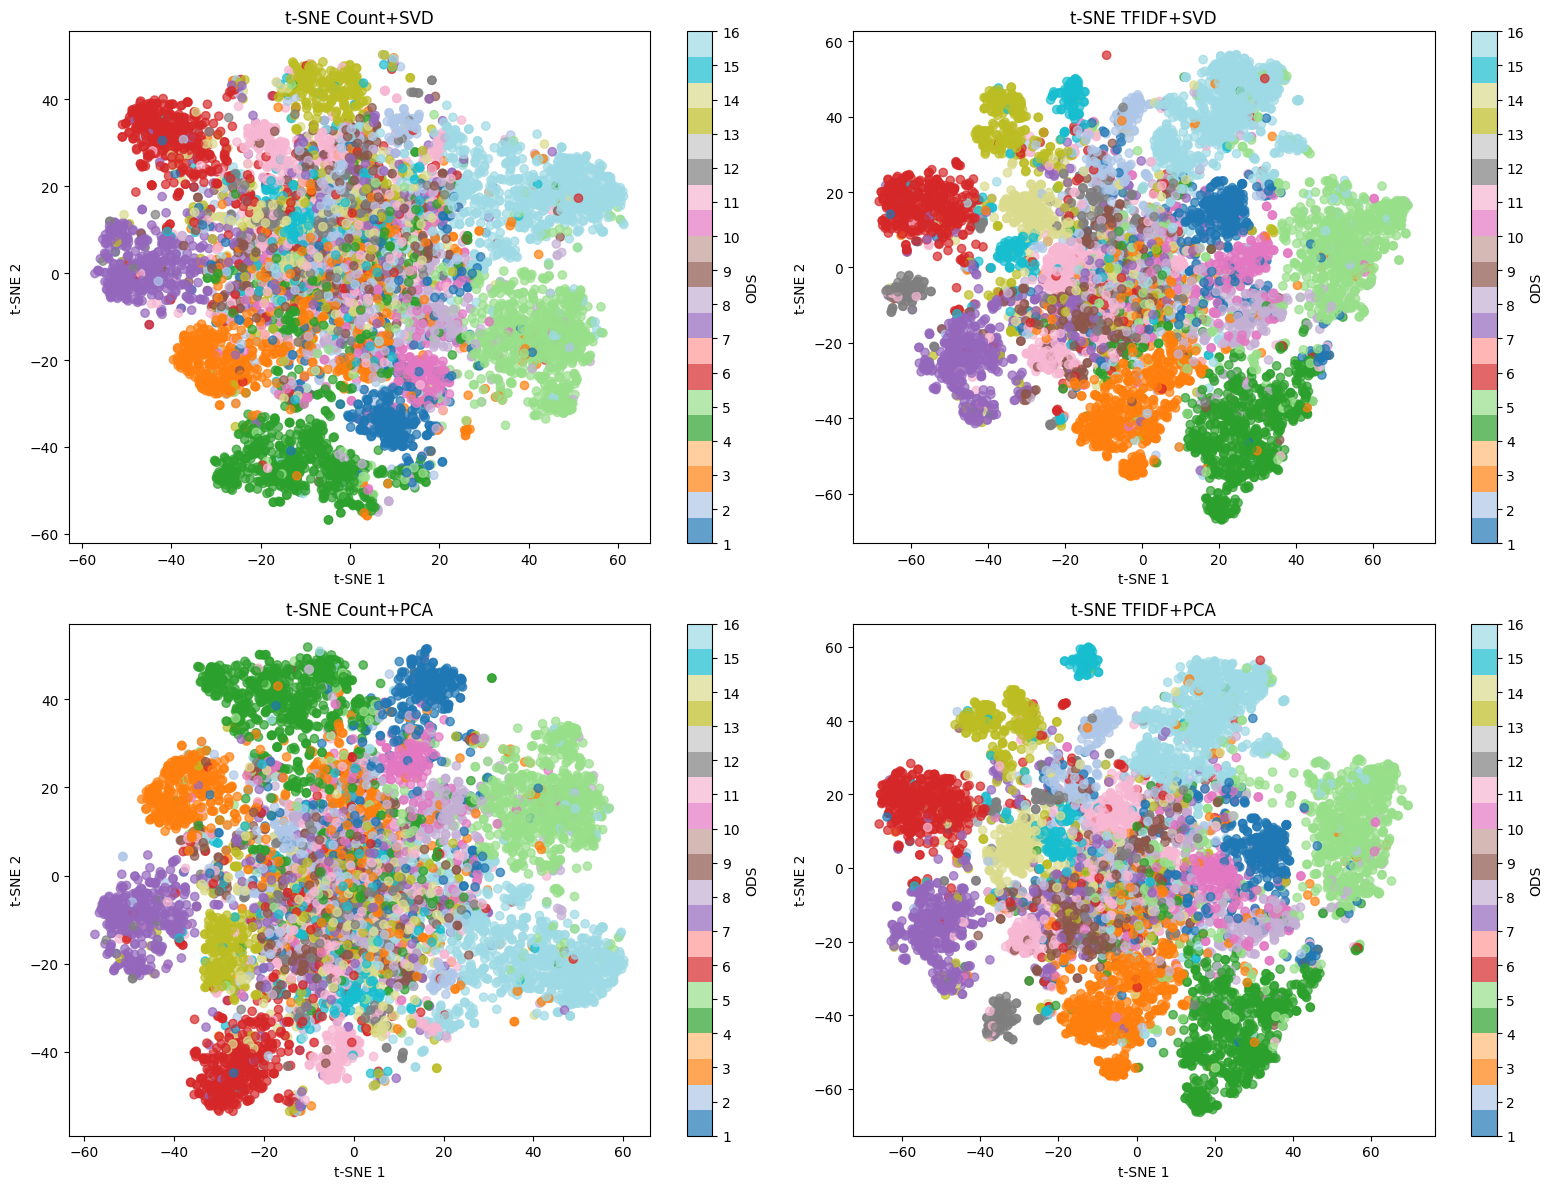

In [29]:
nombres = ['Count+SVD', 'TFIDF+SVD', 'Count+PCA', 'TFIDF+PCA']
labels = y_train.astype(int)

tsne_results = []
for bow in bow_list:
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(bow['train_data'])
    tsne_results.append(tsne_result)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for i, ax in enumerate(axes.flat):
    scatter = ax.scatter(tsne_results[i][:,0], tsne_results[i][:,1], c=labels, cmap='tab20', alpha=0.7)
    ax.set_title(f't-SNE {nombres[i]}')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    cbar = plt.colorbar(scatter, ax=ax, ticks=range(1,17))
    cbar.set_label('ODS')

plt.tight_layout()
plt.show()

__Factory de Pipelines para los Modelos de Clasificación__ De manera análoga a la fábrica de datos, esta clase se encarga de construir el pipeline para el modelo de clasificación y definir una configuración de hiperparámetros para la optimización (param_grid).

Soporta tres algoritmos: LogisticRegression, RandomForestClassifier y KNeighborsClassifier. Este enfoque modular facilita la prueba y comparación de diferentes algoritmos, esto permite contrastar los diferentes modelos de clasificación.

In [30]:
class ModelPipelineFactory:
    def get_pipelines_and_params(self, algorithm):

        if algorithm == 'logistic':
            model = LogisticRegression(max_iter=2000)
            param_grid = {
                'model__C': [0.1, 1, 10],
                'model__solver': ['lbfgs', 'saga']
            }
        elif algorithm == 'randomforest':
            model = RandomForestClassifier()
            param_grid = {
                'model__n_estimators': [100, 200],
                'model__max_depth': [None, 10, 20]
            }
        elif algorithm == 'kneighbors':
            model = KNeighborsClassifier()
            param_grid = {
                'model__n_neighbors': [3, 5, 7],
                'model__weights': ['uniform', 'distance']
            }
        else:
            raise ValueError(f"Algoritmo no soportado: {algorithm}")

        steps = [
            ('model', model)            
        ]

        pipeline = Pipeline(steps)
        return pipeline, param_grid

__Función helper para visualizar la Evaluación__ esta función estandariza la visualización de los resultados de aplicar un algoritmos de clasificación a una bolsa de palabras. Recibe las etiquetas verdaderas y las predicciones, y genera dos visualizaciones:
1. Un reporte de clasificación (classification_report) que muestra métricas como precisión, recall y f1-score por cada clase.
2. Una matriz de confusión (confusion_matrix) que visualiza los aciertos y errores del modelo. Esta función es clave para cumplir con el requisito de evaluación del modelo

In [31]:
def print_reports(y_test, y_pred, title):    
    # Reporte de clasificación como tabla
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Tabla de reporte de clasificación
    ax1.axis('off')
    table = ax1.table(cellText=df_report.round(2).values,
                    colLabels=df_report.columns,
                    rowLabels=df_report.index,
                    loc='center',
                    cellLoc='center')
    ax1.set_title('Reporte de Clasificación: ' + title)

    # Matriz de confusión con ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax2, cmap=plt.cm.Blues)
    ax2.set_title('Matriz de Confusión')

    plt.tight_layout()
    plt.show()

In [32]:
algorithms = ['logistic', 'randomforest', 'kneighbors']


__Ciclos de Entrenamiento, Optimización y Evaluación__ Este es el núcleo del proyecto, donde se unen todos los componentes anteriores. Ejecuta cada algoritmo de clasificación para cada una de las bolsas de palabras preparadas previamente:
1. Optimización: La búsqueda de hiperparámetros se realiza con GridSearchCV usando validación cruzada de 3 subconjuntos (folds). Tras varios intentos decidimos usar el f1_macro como scoring esto debido al desbalance entre clases.
2. Entrenamiento: El GridSearchCV entrena el modelo con los mejores hiperparámetros encontrados.
3. Evaluación: Realiza predicciones sobre el conjunto de prueba (que son los datos no vistos) y utiliza la función helper para visualizar el rendimiento final.

Los resultados impresos muestran que la combinación de regresión logística con vectorización TF-IDF y reducción de dimensionalidad PCA obtiene el mejor score de validación (0.8600), justificando empíricamente su elección como el mejor modelo.

Para interpretar los resultados es relevante tener en cuenta que:
- El classification_report es indispensable porque permite encontrar el mejor modelo que sea de utilidad y confiable para clasificar cada uno de los Objetivos de Desarrollo Sostenible.
- El _support_ muestra que hay desbalance entre las clases, por ejemplo los objetivos 9, 10, 12 y 14 tienen muchas menos muestras, mientras que  los objetivos 4, 5 y 16 son clases mayoritarias.
- El mejor modelo se logro clasificando con regresión logísitica con baja regularización y optmizando con SAGA, el mejor vectorizador fue TF-IDF. El mejor score fue 0.83.

    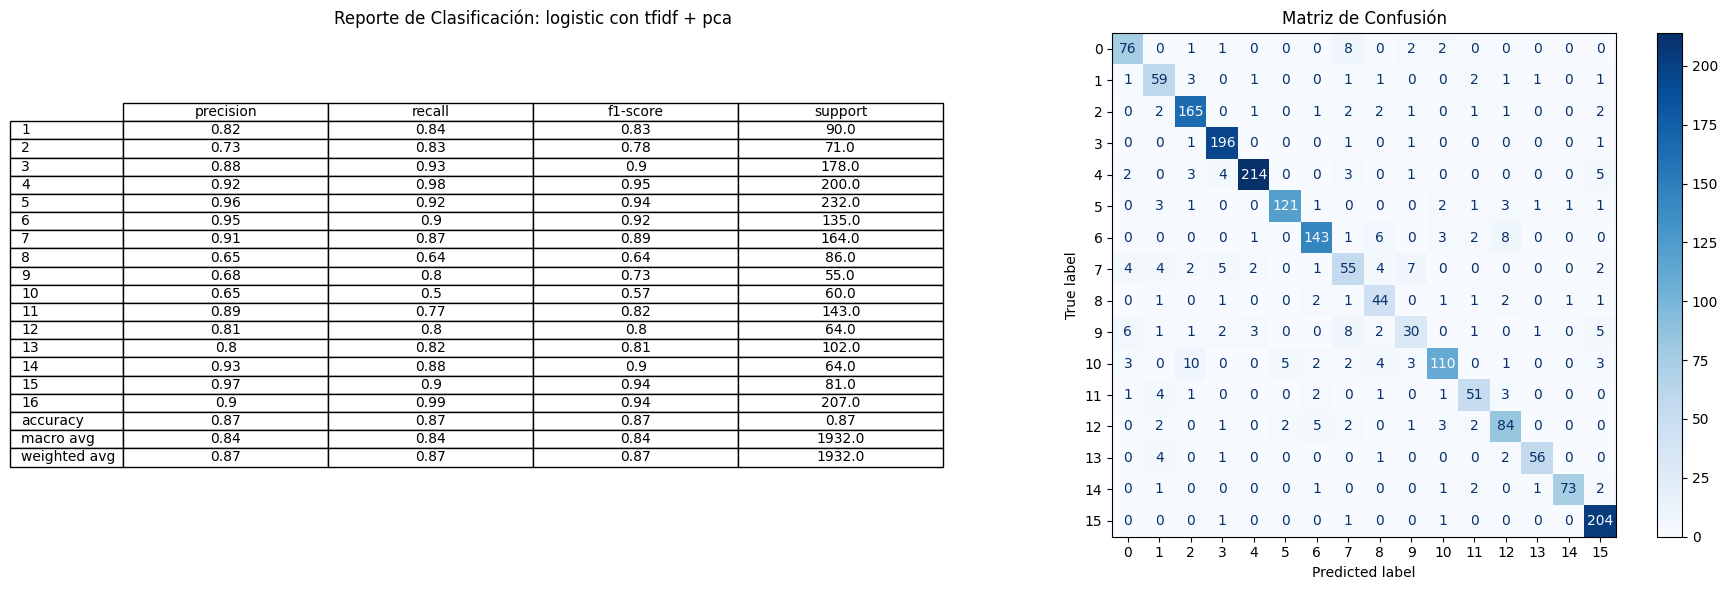

_**ENTRENAMIENTO Y EVALUACION PARA:** logistic con tfidf + pca_, _**Mejores hiperparámetros:** {'model__C': 10, 'model__solver': 'saga'}_, _**Mejor score de validación:** 0.8310934090755154_

ENTRENAMIENTO Y EVALUACION PARA: logistic con count + svd
Mejores hiperparámetros: {'model__C': 0.1, 'model__solver': 'saga'}
Mejor score de validación: 0.7624120318446684


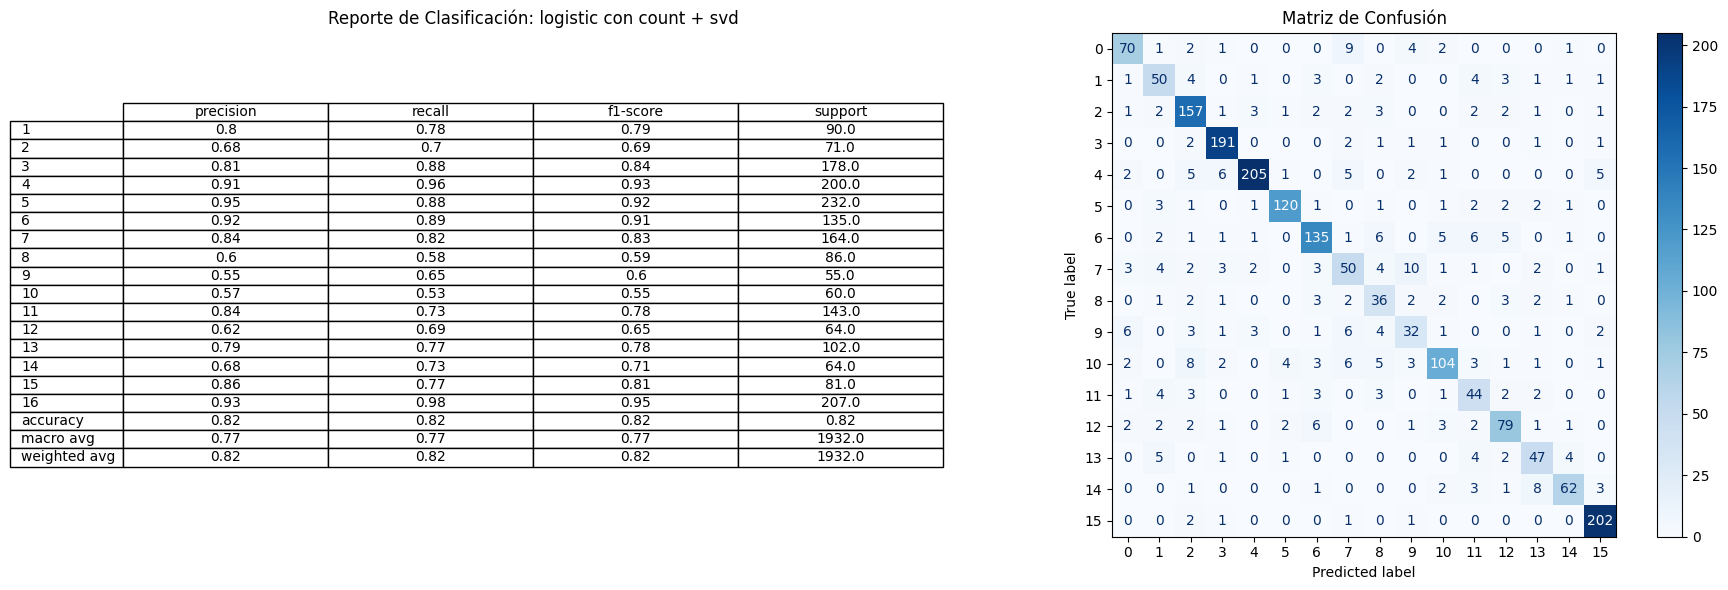

ENTRENAMIENTO Y EVALUACION PARA: logistic con tfidf + svd
Mejores hiperparámetros: {'model__C': 10, 'model__solver': 'saga'}
Mejor score de validación: 0.8306077239239223


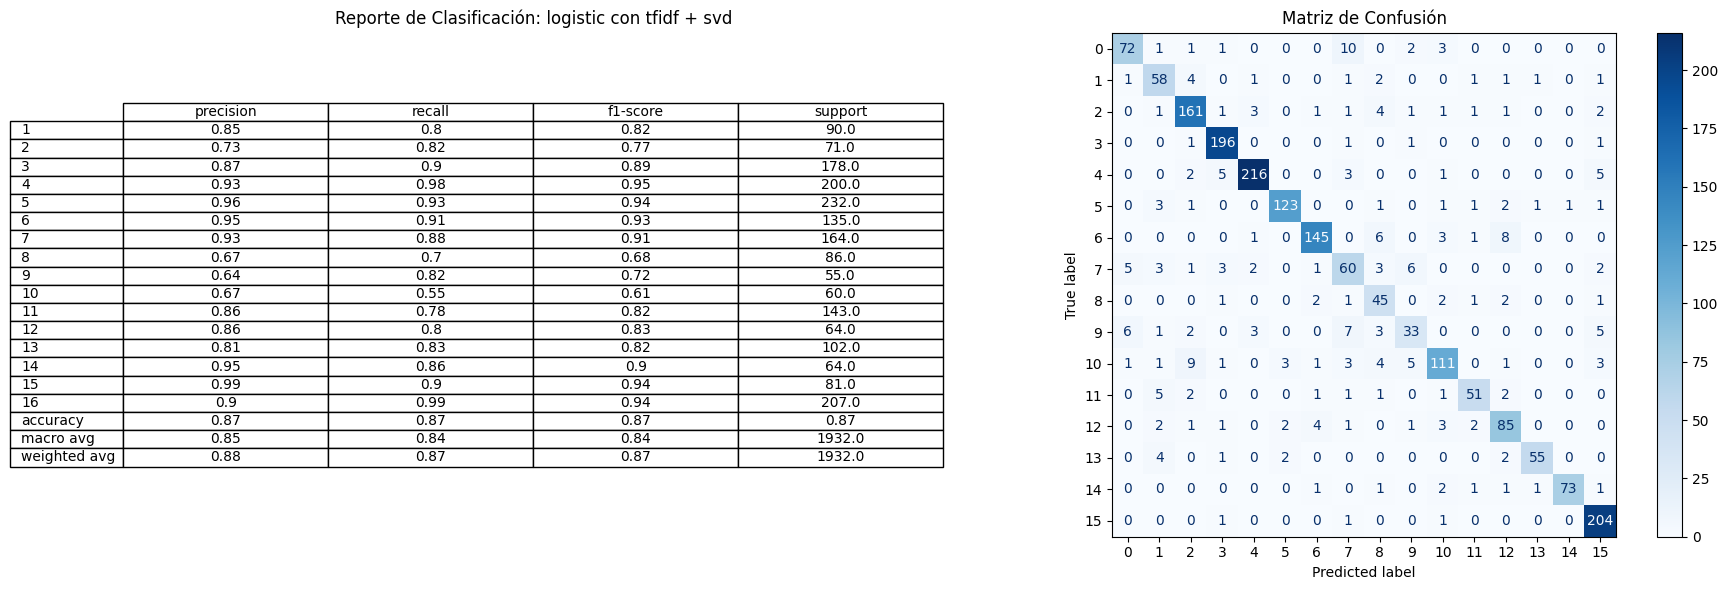

ENTRENAMIENTO Y EVALUACION PARA: logistic con count + pca
Mejores hiperparámetros: {'model__C': 0.1, 'model__solver': 'saga'}
Mejor score de validación: 0.7576719075963072


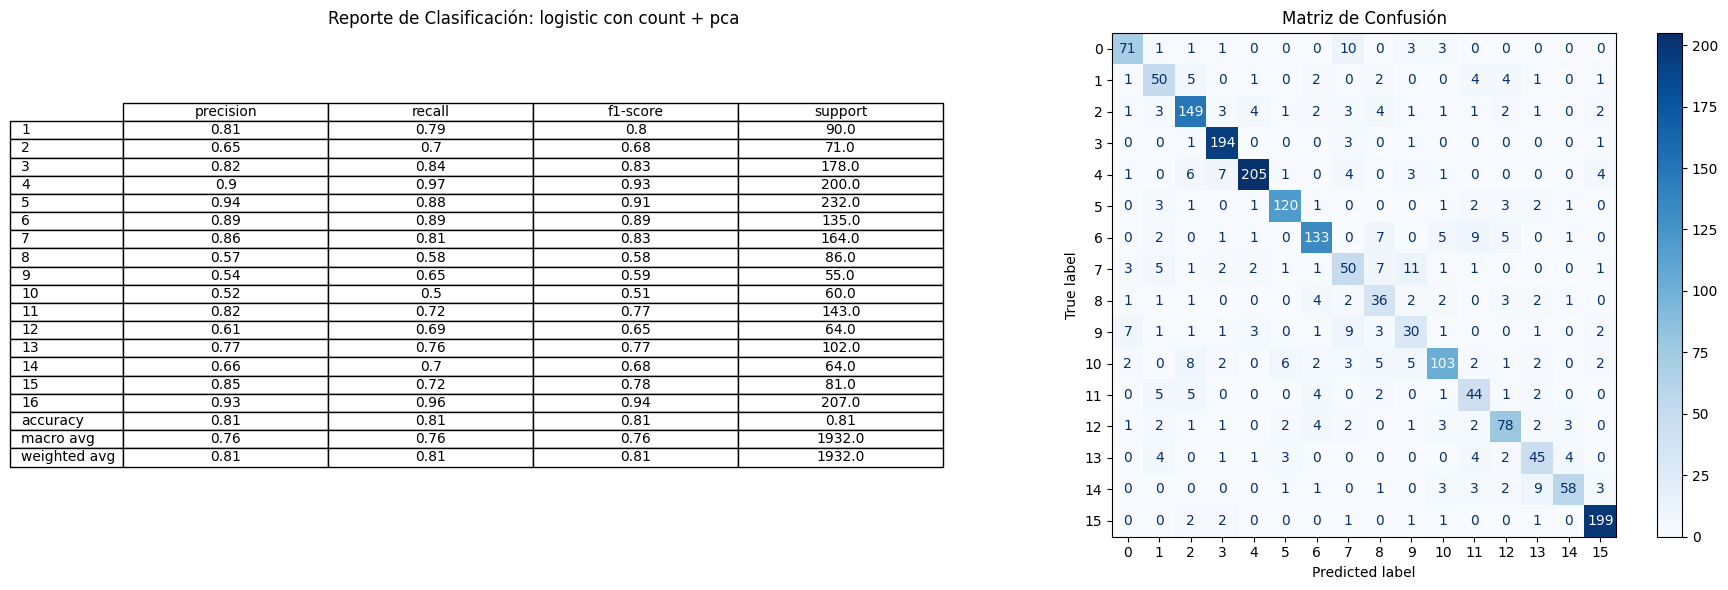

ENTRENAMIENTO Y EVALUACION PARA: logistic con tfidf + pca
Mejores hiperparámetros: {'model__C': 10, 'model__solver': 'saga'}
Mejor score de validación: 0.8310934090755154


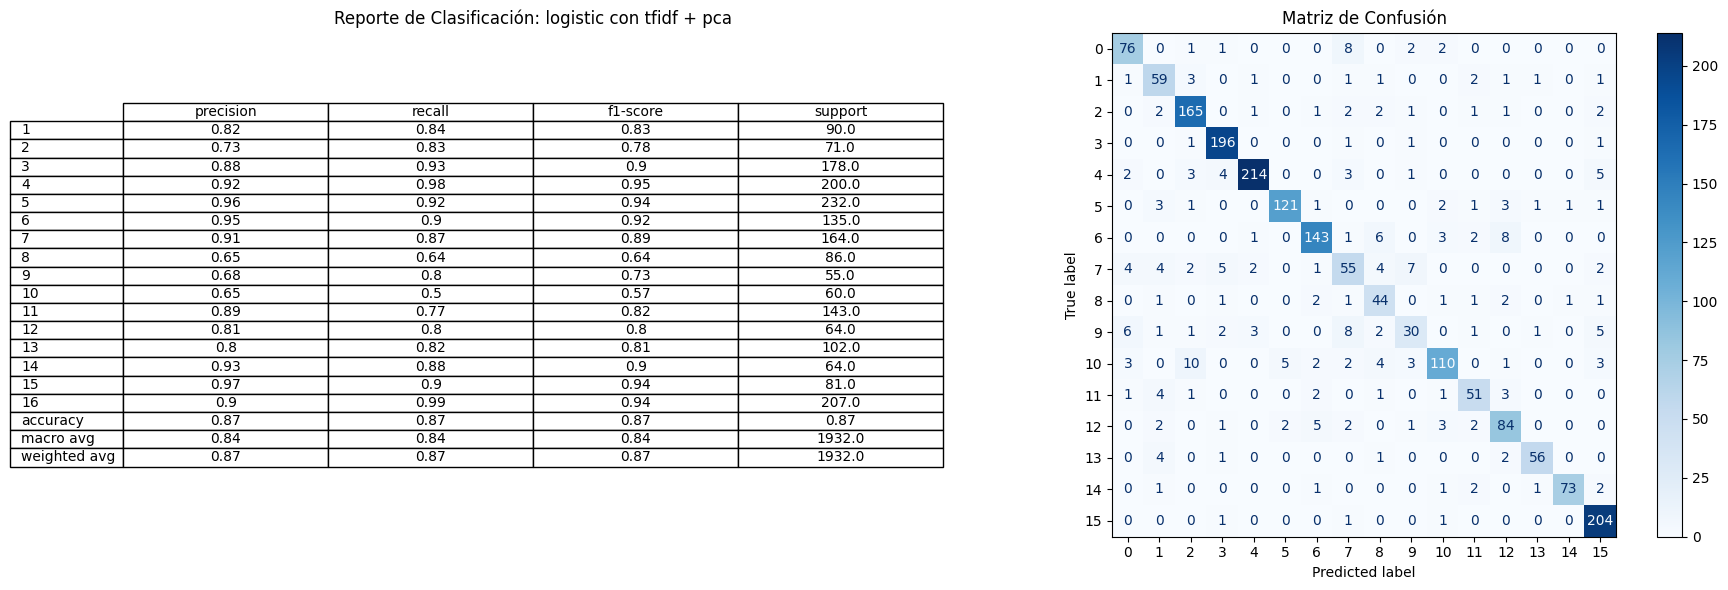

ENTRENAMIENTO Y EVALUACION PARA: randomforest con count + svd
Mejores hiperparámetros: {'model__max_depth': None, 'model__n_estimators': 200}
Mejor score de validación: 0.6691230465499712


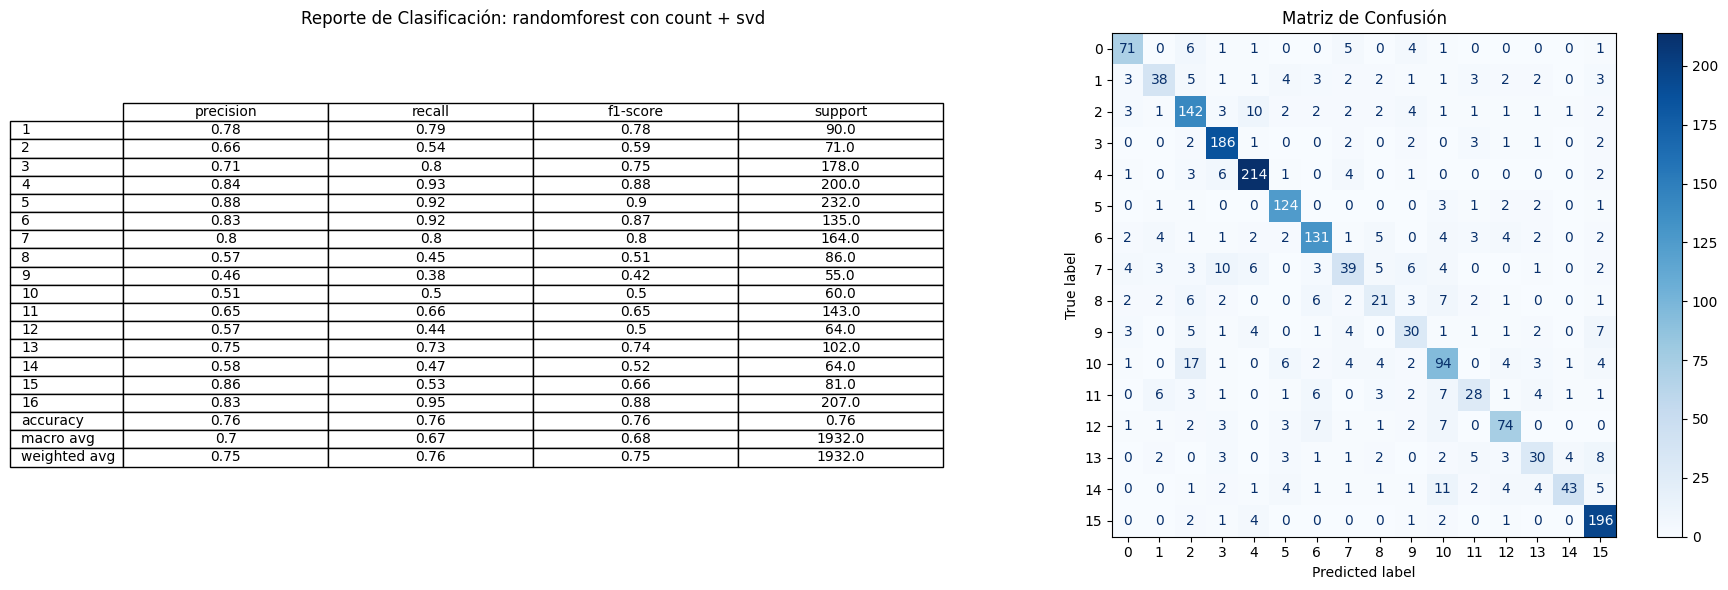

ENTRENAMIENTO Y EVALUACION PARA: randomforest con tfidf + svd
Mejores hiperparámetros: {'model__max_depth': 20, 'model__n_estimators': 200}
Mejor score de validación: 0.7899983371132836


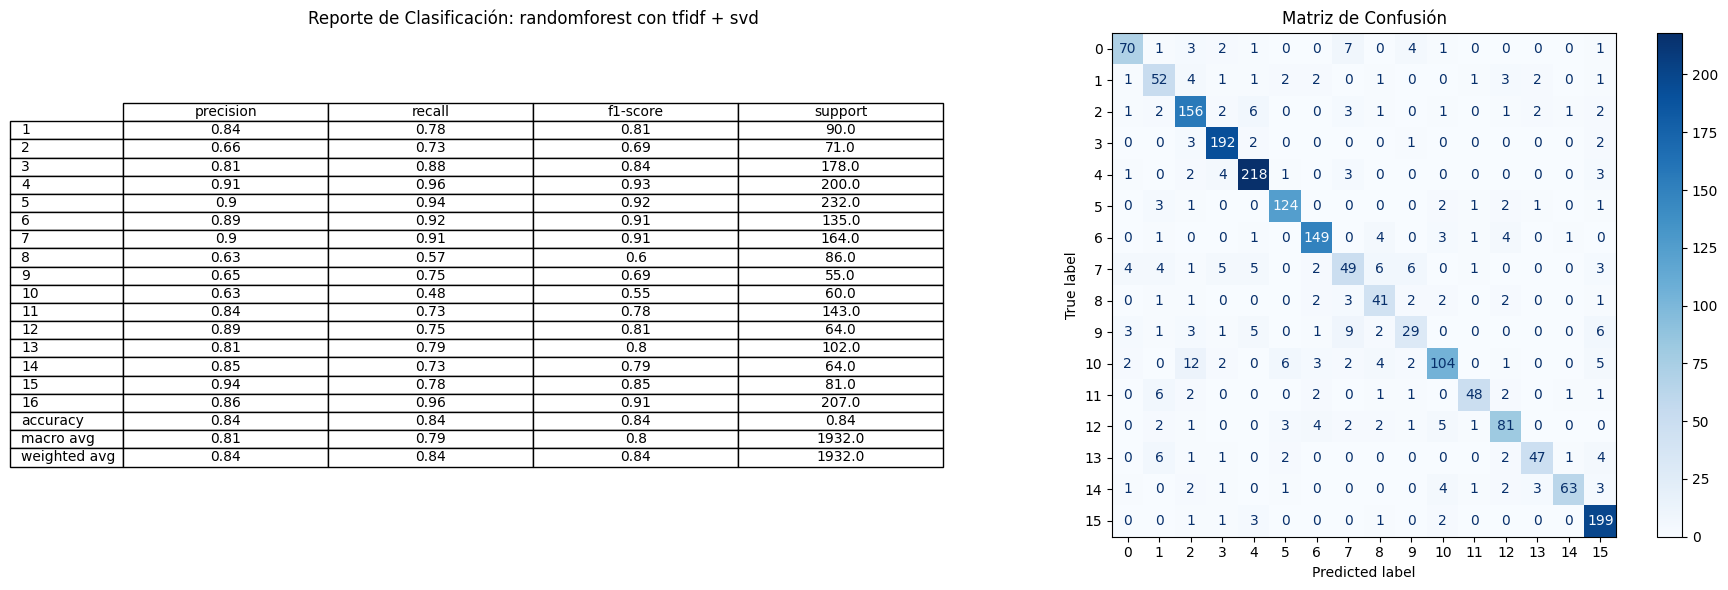

ENTRENAMIENTO Y EVALUACION PARA: randomforest con count + pca
Mejores hiperparámetros: {'model__max_depth': 20, 'model__n_estimators': 200}
Mejor score de validación: 0.6688786074431777


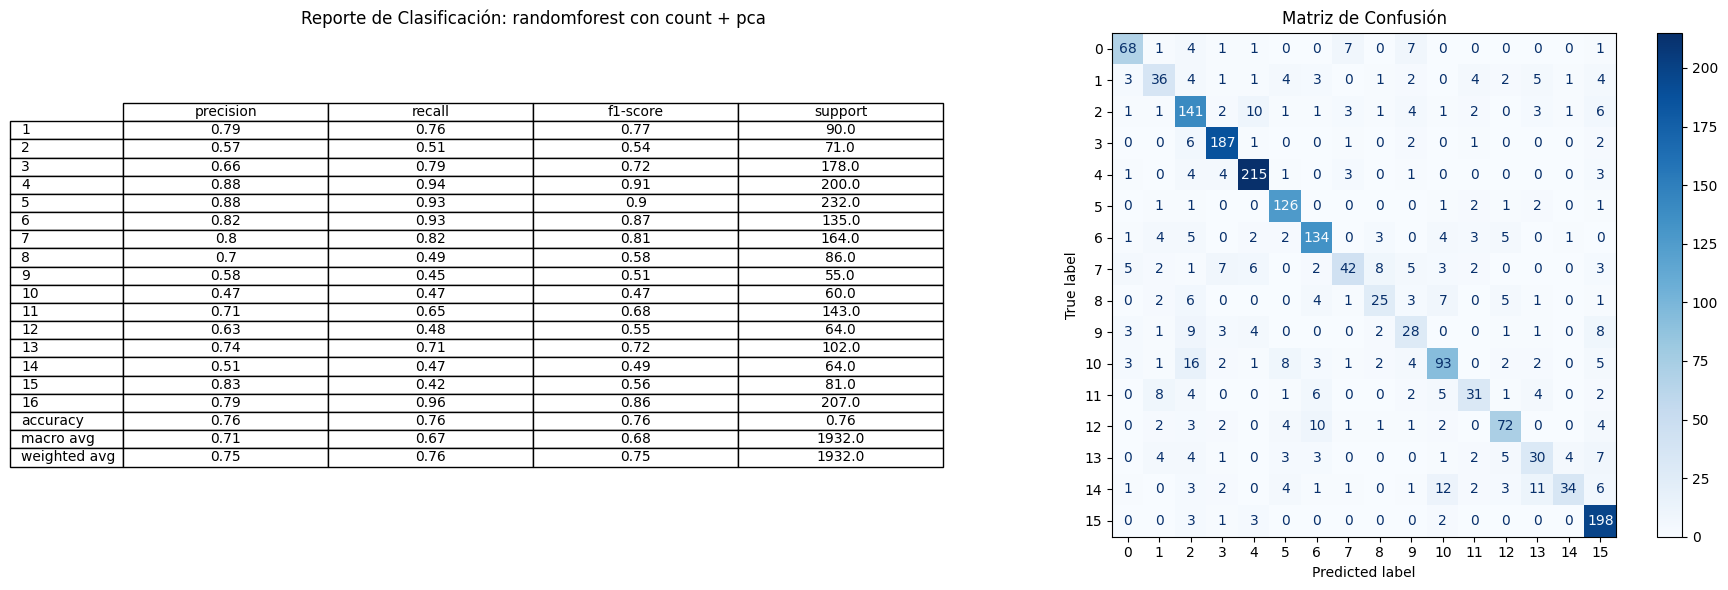

ENTRENAMIENTO Y EVALUACION PARA: randomforest con tfidf + pca
Mejores hiperparámetros: {'model__max_depth': None, 'model__n_estimators': 200}
Mejor score de validación: 0.786697795913721


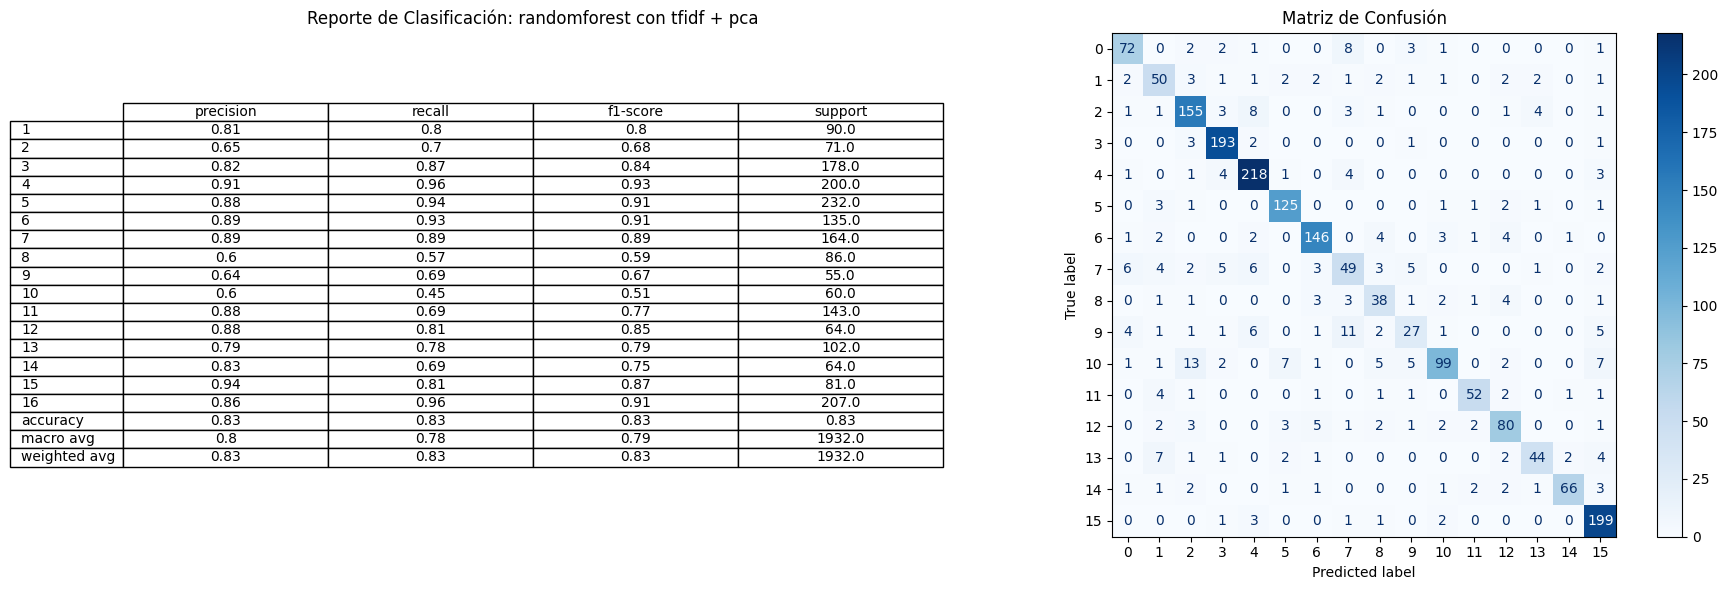

ENTRENAMIENTO Y EVALUACION PARA: kneighbors con count + svd
Mejores hiperparámetros: {'model__n_neighbors': 7, 'model__weights': 'distance'}
Mejor score de validación: 0.5722586143506155


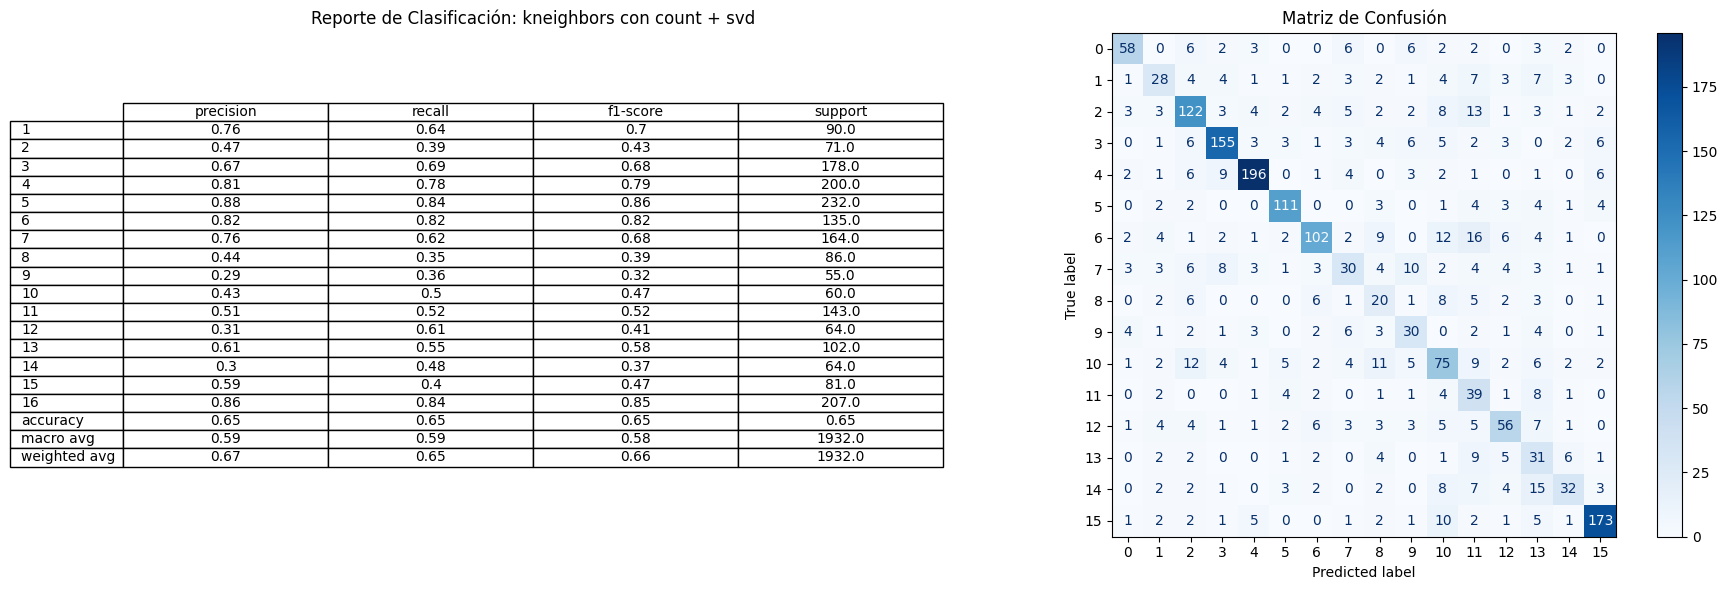

ENTRENAMIENTO Y EVALUACION PARA: kneighbors con tfidf + svd
Mejores hiperparámetros: {'model__n_neighbors': 7, 'model__weights': 'distance'}
Mejor score de validación: 0.7356982435964241


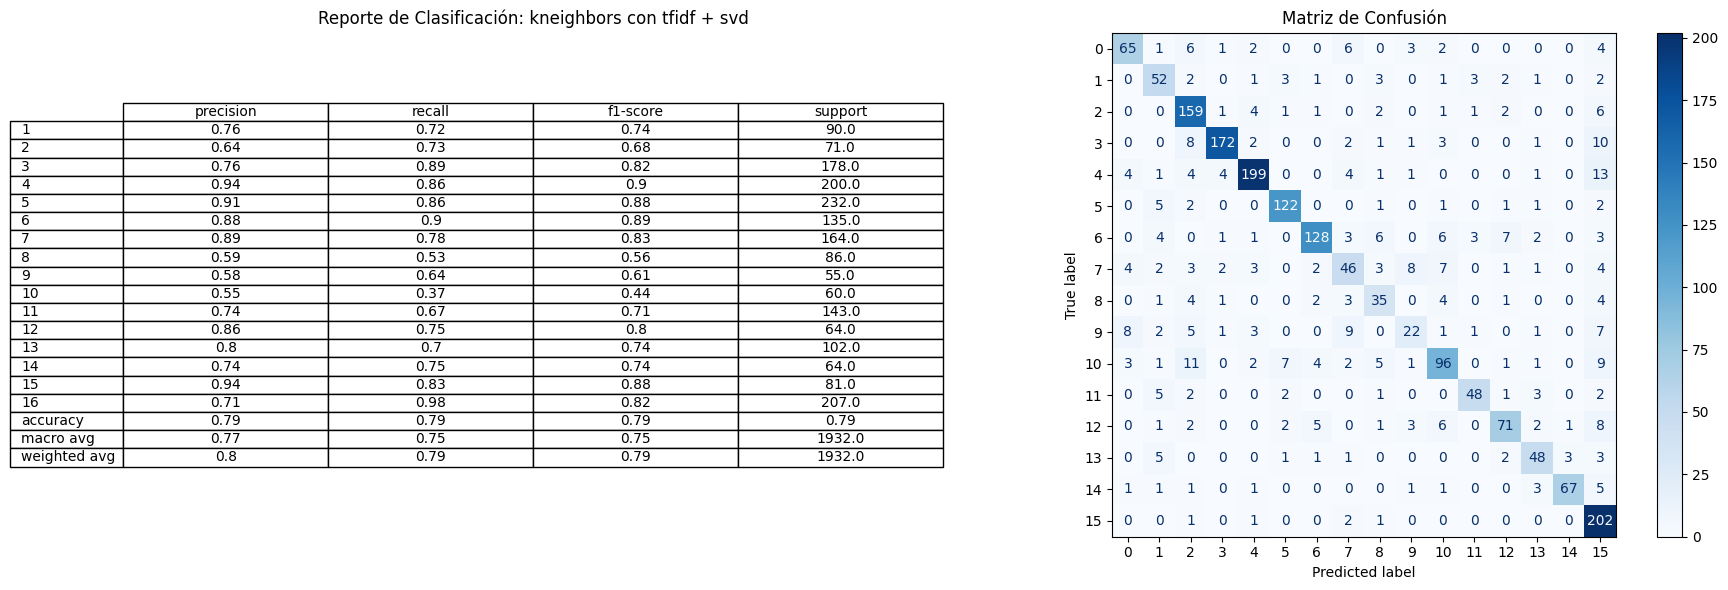

ENTRENAMIENTO Y EVALUACION PARA: kneighbors con count + pca
Mejores hiperparámetros: {'model__n_neighbors': 7, 'model__weights': 'distance'}
Mejor score de validación: 0.5764348593517458


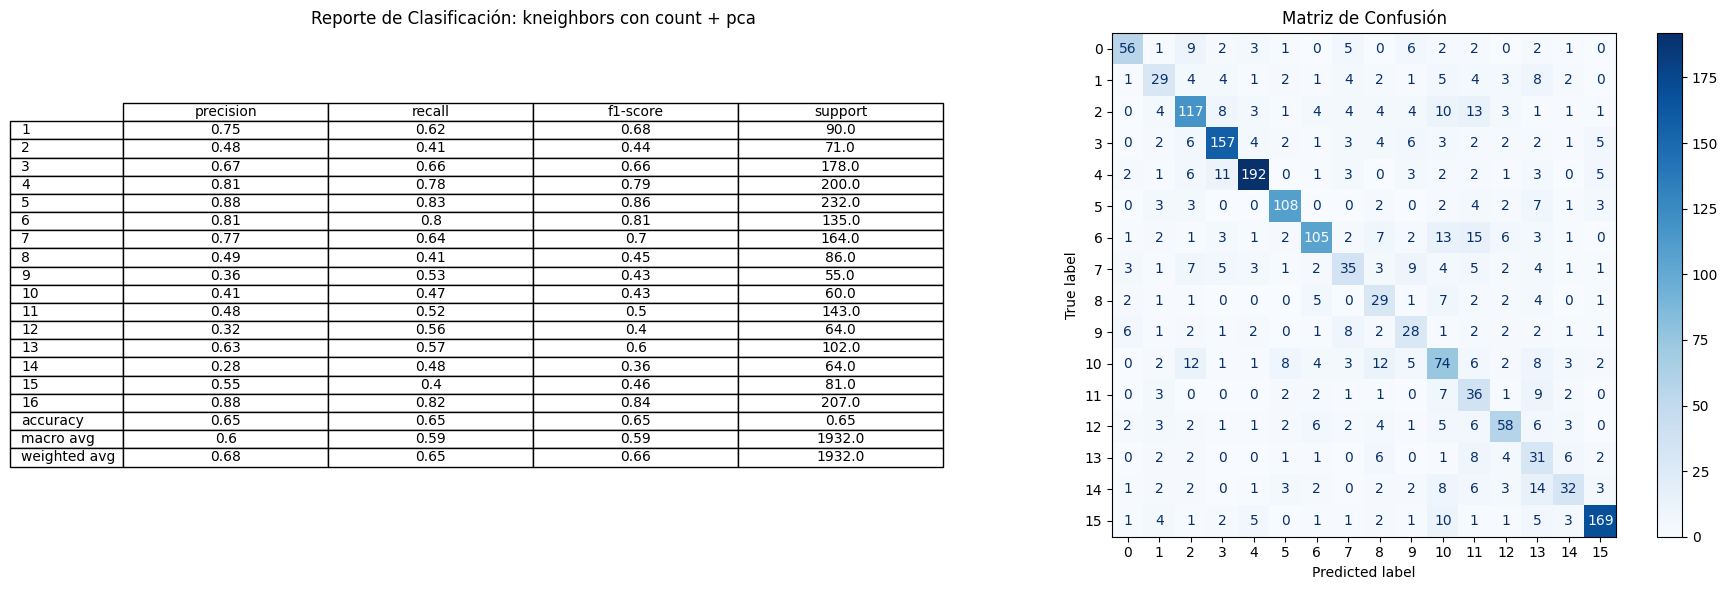

ENTRENAMIENTO Y EVALUACION PARA: kneighbors con tfidf + pca
Mejores hiperparámetros: {'model__n_neighbors': 7, 'model__weights': 'distance'}
Mejor score de validación: 0.7347599126779709


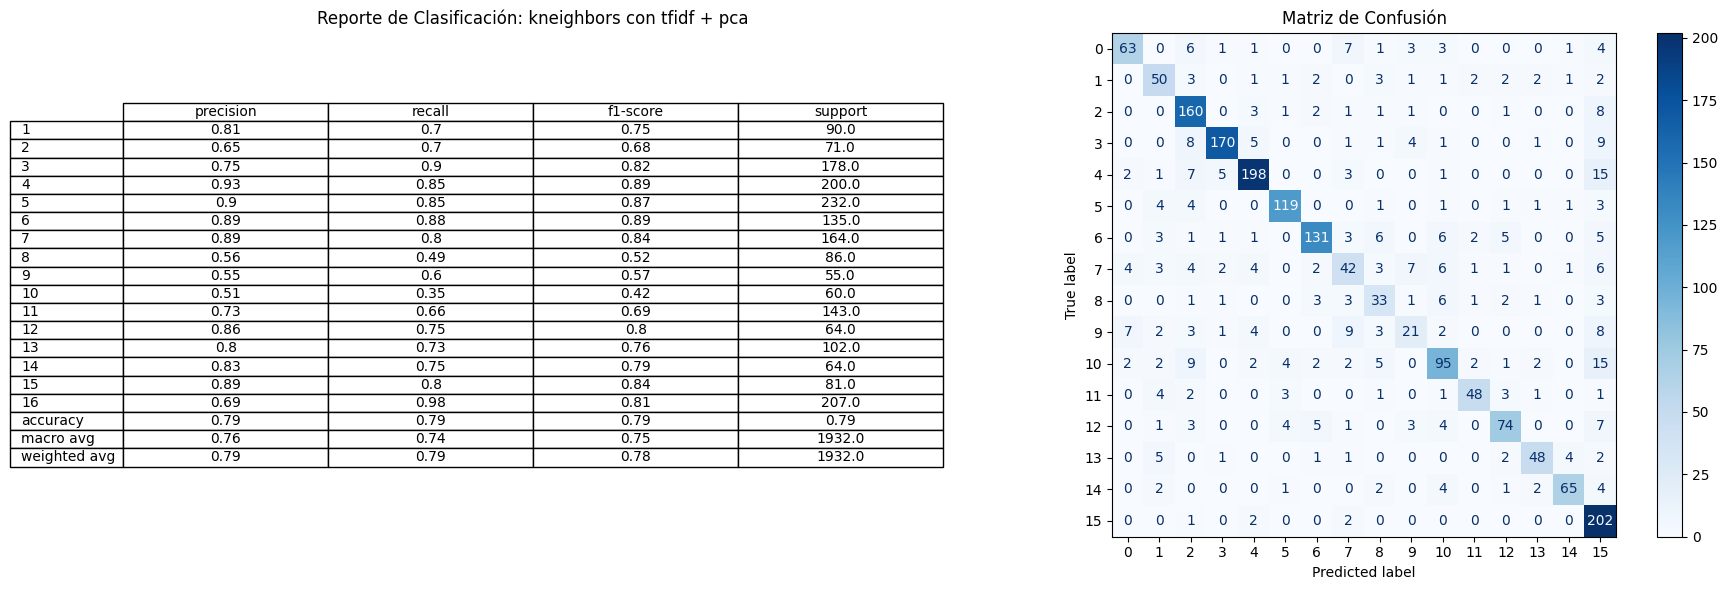

In [35]:
for algorithm in algorithms:
    for bow in bow_list:
        title = f"{algorithm} con {bow['vectorized']} + {bow['reduction']}"
        print("ENTRENAMIENTO Y EVALUACION PARA:", title)
        pipelineFactory = ModelPipelineFactory()
        pipeline, params = pipelineFactory.get_pipelines_and_params(algorithm)
        grid = GridSearchCV(pipeline, params, cv=3, scoring='f1_macro', n_jobs=-1)
        grid.fit(bow['train_data'], y_train)
        print("Mejores hiperparámetros:", grid.best_params_)
        print("Mejor score de validación:", grid.best_score_)
        
        y_pred = grid.predict(bow['test_data'])
        
        print_reports(y_test, y_pred, title)     
        

__Evidencia del desempeño del modelo__ Se tomaron seis muestras manualmente directamente del archivo _Train_textosODS.xlsx_ y se predijeron sus ODS usando el pipeline de preprocesamiento y los hiperparámetros que generaron el mejor score.

In [65]:
vectorizer = 'tfidf'
reduction = 'pca'
fitted_preprocessor = DataProcessingPipelineFactory().get_pipelines_and_params(vectorizer, reduction)
fitted_preprocessor.fit(x_train)


Pipeline(steps=[('preprocess', TextPreprocessorTransformer()),
                ('vectorizer', TfidfVectorizer()),
                ('to_dense', ToDenseTransformer()),
                ('dimred', PCA(n_components=100))])

In [69]:
prediction_bow = bow_list[3]  # TF-IDF + PCA
model = LogisticRegression(max_iter=2000).set_params(**{'C': 10, 'solver': 'saga'})
model.fit(prediction_bow['train_data'], y_train)

LogisticRegression(C=10, max_iter=2000, solver='saga')

De los seis textos seleccionados manualmente, 5 se clasificaron exitosamente, sólo el penúltimo _text_ods_12_2_, correspodiente a la clase 12 fue clasificado como 16. A propósito se seleccionaron dos muestras de la clase 12 ya que es una de las que está subrepresentada en el dataset, segun la métrica _support_.

In [68]:
text_ods_4 = "Para los niños más pequeños (bebés y niños pequeños), la capacitación especializada y práctica parece estar más fuertemente asociada con la calidad pedagógica y los resultados cognitivos y sociales. Los educadores de la primera infancia se encuentran con entornos sociales cada vez más complejos y se encuentran con una multiplicidad de antecedentes y experiencias familiares. Estos factores crean imperativos para adoptar nuevas pedagogías y prácticas organizacionales para acomodar este pluralismo (Elliott, 2006)."
text_ods_5 = "A las madres adolescentes se les permite continuar su educación en el centro más cercano durante al menos un curso escolar, y luego volver al sistema escolar formal tras el nacimiento de sus hijos. Para sobrevivir con mis hijos, trabajo en los jardines de la gente por 700 francos ruandeses [alrededor de 1 dólar] al día o lavo la ropa de la gente. En comparación con las madres adolescentes que no participan en el programa del Centro, el índice de repetición de embarazos ha sido menor entre las niñas del programa, y más niñas han continuado su educación, incluso presentándose a exámenes y reincorporándose al sistema educativo formal. Las intervenciones más exitosas han promovido la igualdad de género, han ayudado a mantener a las niñas en la escuela o han reducido la pobreza y los incentivos económicos para los matrimonios infantiles entre los segmentos más desfavorecidos de la sociedad (Blum et al., Desarrollado por el Instituto de Salud Reproductiva y ejecutado en Ruanda junto con los Servicios Católicos de Socorro, el proyecto aumentó los conocimientos y mejoró la comunicación entre niños y padres sobre sexualidad y roles de género."
text_ods_12 = "Existe una clara necesidad de aumentar la coordinación y el intercambio de información entre los agentes, en particular entre diseñadores/marcas/productores y clasificadores/empresas de reciclaje y técnicos que desarrollen nuevas tecnologías de reciclaje (Elander y Ljungkvist, 2016). Es necesario garantizar un suministro fiable de textiles usados reciclables y aumentar la demanda de fibras, hilos y tejidos con contenido reciclado. De especial interés son los ejemplos de bucles completamente cerrados. Esto se explica con más detalle en el siguiente capítulo."
text_ods_14 = "En el Ártico, los temas clave incluyen la mejora de la coordinación de las pesquerías bajo jurisdicción nacional e internacional, la respuesta del sector pesquero a los cambios en los ecosistemas y la mejora de los enfoques de precaución y ecosistémicos. Sin embargo, lo que exploraremos es el desarrollo del régimen en la Antártida y los instrumentos de política un tanto únicos que ha producido para abordar los enfoques ecosistémicos y de precaución. Este documento plantea la pregunta: a pesar de las diferentes diferencias ecológicas y políticas, ¿pueden utilizarse algunos de los enfoques innovadores en la Antártida para reformar la gestión del Ártico?"
text_ods_12_2 = "Los avances en el régimen jurídico nuclear internacional han permitido un marco de entendimiento en torno a los desechos radiactivos, con la definición de conceptos relevantes y el establecimiento de estrategias de eliminación. El Convenio de Basilea de 1989 sobre el control de los movimientos transfronterizos de desechos peligrosos y su eliminación fue estableciéndose como un elemento importante a nivel mundial, de forma que su contenido se tomó como punto de partida para las políticas de los múltiples gobiernos. El Convenio de Londres de 1972 y la Convención OSPAR de 1992 también tuvieron un impacto decisivo al insertar los principios de la gestión ambiental"
text_ods_11 = "Las cifras consolidadas de 2017 en Bogotá sugieren que mientras 19 ocupantes de automóviles privados murieron en accidentes de tránsito, 133 (siete veces más) UVV murieron en choques que involucraron un automóvil privado. Por otro lado, en un año en el que murieron 59 ciclistas, solo tres peatones murieron en colisiones con bicicletas de pedales. Esto ilustra el impacto significativo de un grupo de usuarios de la vía sobre los demás, relativamente modesto en el caso de las bicicletas de pedal, pero abrumador en el caso de los automóviles privados. Los taxis están claramente separados en las estadísticas de colisiones, algo de lo que otros gobiernos podrían aprender."


for text in [text_ods_4, text_ods_5, text_ods_12, text_ods_14, text_ods_12_2, text_ods_11]:
    print("\nTexto a clasificar:\n", text)
    preprocessed_text =  fitted_preprocessor.transform(pd.Series([text]))
    print(f"Predicted ODS: {model.predict(preprocessed_text)[0]}")



Texto a clasificar:
 Para los niños más pequeños (bebés y niños pequeños), la capacitación especializada y práctica parece estar más fuertemente asociada con la calidad pedagógica y los resultados cognitivos y sociales. Los educadores de la primera infancia se encuentran con entornos sociales cada vez más complejos y se encuentran con una multiplicidad de antecedentes y experiencias familiares. Estos factores crean imperativos para adoptar nuevas pedagogías y prácticas organizacionales para acomodar este pluralismo (Elliott, 2006).
Predicted ODS: 4

Texto a clasificar:
 A las madres adolescentes se les permite continuar su educación en el centro más cercano durante al menos un curso escolar, y luego volver al sistema escolar formal tras el nacimiento de sus hijos. Para sobrevivir con mis hijos, trabajo en los jardines de la gente por 700 francos ruandeses [alrededor de 1 dólar] al día o lavo la ropa de la gente. En comparación con las madres adolescentes que no participan en el progra

__Conclusiones__
En este proyecto se desarrolló una solución de machine learning para clasificar textos según los 17 Objetivos de Desarrollo Sostenible (ODS), abordando la necesidad de automatizar el análisis de información textual para organizaciones como la UNFPA.

El trabajo se estructuró mediante pipelines de sklearn que integraron sistemáticamente varias etapas. Primero, se realizó un preprocesamiento de texto que incluyó tokenización, eliminación de stopwords y stemming. Posteriormente, se representaron los textos numéricamente utilizando el esquema de bolsa de palabras (BOW), probando tanto la ponderación TF-IDF como el conteo simple de frecuencias.

Un aspecto central fue la reducción de la dimensionalidad, un requisito clave para manejar la complejidad de los datos textuales y mejorar el rendimiento de los modelos. Para ello, se aplicaron y compararon dos técnicas de extracción de características: Análisis de Componentes Principales (PCA) y Descomposición en Valores Singulares (SVD), la cual es la base del Análisis Semántico Latente (LSI). Finalmente, se entrenaron y optimizaron tres algoritmos de clasificación distintos (LogisticRegression, RandomForestClassifier y KNeighborsClassifier) mediante una búsqueda exhaustiva de hiperparámetros con GridSearchCV.

Los resultados de este proceso experimental muestran que el enfoque fue efectivo. La evaluación las combinaciones de vectorización, reducción de dimensionalidad y algoritmos de clasificación permitió identificar una configuración óptima con base en evidencia empírica. El modelo con el mejor desempeño fue el de Regresión Logística, que alcanzó un score de validación del 86%. Este resultado se obtuvo al combinar la representación vectorial de textos mediante TF-IDF con la técnica de reducción de dimensionalidad PCA.

La conclusión principal es que la extracción de características como PCA o SVD es fundamental para transformar la representación de alta dimensionalidad de los textos en un espacio semántico de menor dimensionalidad. Esta nueva representación, que captura conceptos en lugar de términos aislados, permitió que el modelo de clasificación alcanzara un alto rendimiento, cumpliendo con éxito el objetivo de construir una solución consistente para la clasificación automática de textos en el contexto de los ODS.